In [8]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict
import seaborn as sns
import os

In [9]:
image_path = "../figures/eda"
# create EDA folder if it doesn't exist
if not os.path.exists(image_path):
    os.makedirs(image_path)
    print("Created 'eda' folder for saving plots")


sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [10]:
class DualIndex:
    """Bidirectional index for user-movie ratings."""
    
    def __init__(self):
        self.user_ratings = []
        self.idx_to_user = []
        self.user_to_idx = {}
        
        self.movie_ratings = []
        self.idx_to_movie = []
        self.movie_to_idx = {}
       
    def add_rate(self, userId, movieId, rating):
        """Add a rating to both user and movie indices."""
        # Add to user index
        if userId in self.user_to_idx:
            u_idx = self.user_to_idx[userId]
        else:
            u_idx = len(self.idx_to_user)
            self.user_to_idx[userId] = u_idx
            self.idx_to_user.append(userId)
            self.user_ratings.append([])
        
        self.user_ratings[u_idx].append((movieId, rating))
        
        # Add to movie index
        if movieId in self.movie_to_idx:
            m_idx = self.movie_to_idx[movieId]
        else:
            m_idx = len(self.idx_to_movie)
            self.movie_to_idx[movieId] = m_idx
            self.idx_to_movie.append(movieId)
            self.movie_ratings.append([])
        
        self.movie_ratings[m_idx].append((userId, rating))
    
    def get_user_ratings(self, userId):
        """Get all ratings by a user."""
        if userId not in self.user_to_idx:
            return []
        return list(self.user_ratings[self.user_to_idx[userId]])
    
    def get_movie_raters(self, movieId):
        """Get all users who rated a movie."""
        if movieId not in self.movie_to_idx:
            return []
        return list(self.movie_ratings[self.movie_to_idx[movieId]])

In [11]:
def load_ratings(path_to_ratings_csv, ds):
    """Load ratings from CSV file into DualIndex."""
    with open(path_to_ratings_csv, "r", encoding="utf-8") as f:
        next(f)  # Skip header
        
        for line in f:
            userId_str, movieId_str, rating_str, timestamp_str = line.strip().split(",")
            userId = int(userId_str)
            movieId = int(movieId_str)
            rating = float(rating_str)
            ds.add_rate(userId, movieId, rating)

def load_movies_with_genre(path):
    movies_with_genres = []
    with open(path, "r", encoding="utf-8") as f:
        next(f)  # skip header if exists
        for line in f:
            line = line.rstrip("\n")
            first_comma = line.find(",")
            movie_id = int(line[:first_comma])
            last_comma = line.rfind(",")
            title = line[first_comma+1:last_comma]
            genre_str = line[last_comma+1:]
            genres = genre_str.split("|") if genre_str else []
            movies_with_genres.append((movie_id, title, genres))
    return movies_with_genres


In [12]:

# EDA functions

def analyze_genre_distribution(movies_with_genres, image_path):
    """ Genre Distribution - Histogram """
    genre_counter = Counter()
    
    for movie_id, title, genres in movies_with_genres:
        for genre in genres:
            if genre:  # Skip empty genres
                genre_counter[genre] += 1
    
    # Sort by frequency
    sorted_genres = sorted(genre_counter.items(), key=lambda x: x[1], reverse=True)
    genres, counts = zip(*sorted_genres) if sorted_genres else ([], [])
    
    plt.figure(figsize=(14, 6))
    bars = plt.bar(range(len(genres)), counts, color='steelblue', edgecolor='black', alpha=0.7)
    plt.xlabel('Genre', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Movies', fontsize=12, fontweight='bold')
    plt.title('Genre Distribution of Movies', fontsize=14, fontweight='bold')
    plt.xticks(range(len(genres)), genres, rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=9)
    
    plt.savefig(f'{image_path}/genre_distribution.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\Genre Distribution")
    for genre, count in sorted_genres[:10]:
        print(f"{genre}: {count} movies")
    
    return genre_counter

def analyze_power_law_movies(ds, image_path):
    """ Power Law - Number of Ratings per Movie (Log Scale) """
    # Get number of ratings for each movie
    movie_rating_counts = [len(ratings) for ratings in ds.movie_ratings]
    movie_rating_counts.sort(reverse=True)
    
    # Remove zeros if any
    movie_rating_counts = [x for x in movie_rating_counts if x > 0]
    
    plt.figure(figsize=(12, 6))
    plt.loglog(range(1, len(movie_rating_counts) + 1), movie_rating_counts, 
               'o', markersize=3, alpha=0.6, color='darkblue')
    plt.xlabel('Movie Rank (Log Scale)', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Ratings (Log Scale)', fontsize=12, fontweight='bold')
    plt.title('Power Law Distribution: Movies by Number of Ratings', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, which='both')
    plt.tight_layout()
    plt.savefig(f'{image_path}/power_law_movies.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nMovie Rating Distribution Stats")
    print(f"Total movies: {len(movie_rating_counts)}")
    print(f"Most rated movie: {max(movie_rating_counts)} ratings")
    print(f"Median ratings per movie: {np.median(movie_rating_counts):.1f}")
    print(f"Mean ratings per movie: {np.mean(movie_rating_counts):.1f}")
    print(f"Movies with 1 rating: {sum(1 for x in movie_rating_counts if x == 1)}")
    
    return movie_rating_counts

def analyze_power_law_users(ds, image_path):
    """ Power Law - Number of Ratings per User (Log Scale) """
    # Get number of ratings for each user
    user_rating_counts = [len(ratings) for ratings in ds.user_ratings]
    user_rating_counts.sort(reverse=True)
    
    # Remove zeros if any
    user_rating_counts = [x for x in user_rating_counts if x > 0]
    
    plt.figure(figsize=(12, 6))
    plt.loglog(range(1, len(user_rating_counts) + 1), user_rating_counts, 
               'o', markersize=3, alpha=0.6, color='darkred')
    plt.xlabel('User Rank (Log Scale)', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Ratings (Log Scale)', fontsize=12, fontweight='bold')
    plt.title('Power Law Distribution: Users by Number of Ratings', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, which='both')
    plt.tight_layout()
    plt.savefig(f'{image_path}/power_law_users.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nUser Rating Distribution Stats")
    print(f"Total users: {len(user_rating_counts)}")
    print(f"Most active user: {max(user_rating_counts)} ratings")
    print(f"Median ratings per user: {np.median(user_rating_counts):.1f}")
    print(f"Mean ratings per user: {np.mean(user_rating_counts):.1f}")
    print(f"Users with 1 rating: {sum(1 for x in user_rating_counts if x == 1)}")
    
    return user_rating_counts

def analyze_rating_distribution(ds, image_path):
    """ Rating Distribution - Histogram """

    all_ratings = []
    for user_ratings in ds.user_ratings:
        for movie_id, rating in user_ratings:
            all_ratings.append(rating)
    
    rating_counter = Counter(all_ratings)
    
    plt.figure(figsize=(12, 6))
    ratings = sorted(rating_counter.keys())
    counts = [rating_counter[r] for r in ratings]
    
    bars = plt.bar(ratings, counts, width=0.4, color='forestgreen', edgecolor='black', alpha=0.7)
    plt.xlabel('Rating Value', fontsize=12, fontweight='bold')
    plt.ylabel('Frequency', fontsize=12, fontweight='bold')
    plt.title('Distribution of Movie Ratings', fontsize=14, fontweight='bold')
    plt.xticks(ratings)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10)
    
    plt.savefig(f'{image_path}/rating_distribution.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nRating Distribution")
    total_ratings = sum(counts)
    for rating in ratings:
        count = rating_counter[rating]
        percentage = (count / total_ratings) * 100
        print(f"Rating {rating}: {count} ({percentage:.1f}%)")
    
    print(f"\nMean rating: {np.mean(all_ratings):.2f}")
    print(f"Median rating: {np.median(all_ratings):.2f}")
    print(f"Total ratings: {total_ratings}")
    
    return all_ratings

def analyze_sparsity(ds):
    """ Sparsity Analysis """
    n_users = len(ds.idx_to_user)
    n_movies = len(ds.idx_to_movie)
    total_ratings = sum(len(ratings) for ratings in ds.user_ratings)
    
    possible_ratings = n_users * n_movies
    sparsity = 1 - (total_ratings / possible_ratings)
    
    print("\nSparsity Analysis")
    print(f"Number of users: {n_users:,}")
    print(f"Number of movies: {n_movies:,}")
    print(f"Total ratings: {total_ratings:,}")
    print(f"Possible ratings: {possible_ratings:,}")
    print(f"Sparsity: {sparsity * 100:.4f}%")
    print(f"Density: {(1-sparsity) * 100:.4f}%")

def analyze_temporal_patterns(ds, movies_with_genres, image_path):
    """ Average Rating per Movie (Top 20 Most Rated) """
    # Calculate average rating for each movie
    movie_stats = []
    
    for m_idx, movie_id in enumerate(ds.idx_to_movie):
        ratings = [rating for user_id, rating in ds.movie_ratings[m_idx]]
        if ratings:
            avg_rating = np.mean(ratings)
            num_ratings = len(ratings)
            movie_stats.append((movie_id, avg_rating, num_ratings))
    
    movie_stats.sort(key=lambda x: x[2], reverse=True)
    top_20 = movie_stats[:20]
    
    movie_dict = {mid: title for mid, title, _ in movies_with_genres}
    
    movie_names = []
    avg_ratings = []
    num_ratings = []
    
    for movie_id, avg_rating, n_ratings in top_20:
        title = movie_dict.get(movie_id, f"Movie {movie_id}")
        # Shorten long titles
        if len(title) > 30:
            title = title[:27] + "..."
        movie_names.append(title)
        avg_ratings.append(avg_rating)
        num_ratings.append(n_ratings)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    # fig, ax2 = plt.subplots(1,1, figsize=(14,6))
    
    # Average ratings
    bars1 = ax1.barh(range(len(movie_names)), avg_ratings, color='coral', edgecolor='black', alpha=0.7)
    ax1.set_yticks(range(len(movie_names)))
    ax1.set_yticklabels(movie_names, fontsize=9)
    ax1.set_xlabel('Average Rating', fontsize=11, fontweight='bold')
    ax1.set_title('Top 20 Most Rated Movies - Average Rating', fontsize=13, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    ax1.invert_yaxis()
    
    for i, bar in enumerate(bars1):
        width = bar.get_width()
        ax1.text(width, bar.get_y() + bar.get_height()/2.,
                f'{width:.2f}',
                ha='left', va='center', fontsize=8, fontweight='bold')
    
    # Number of ratings
    bars2 = ax2.barh(range(len(movie_names)), num_ratings, color='skyblue', edgecolor='black', alpha=0.7)
    ax2.set_yticks(range(len(movie_names)))
    ax2.set_yticklabels(movie_names, fontsize=9)
    ax2.set_xlabel('Number of Ratings', fontsize=11, fontweight='bold')
    ax2.set_title('Top 20 Most Rated Movies - Rating Count', fontsize=13, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    ax2.invert_yaxis()
    
    for i, bar in enumerate(bars2):
        width = bar.get_width()
        ax2.text(width, bar.get_y() + bar.get_height()/2.,
                f'{int(width)}',
                ha='left', va='center', fontsize=8, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'{image_path}/top_movies_analysis.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nTop 20 Most Rated Movies")
    for movie_id, avg_rating, n_ratings in top_20[:10]:
        title = movie_dict.get(movie_id, f"Movie {movie_id}")
        print(f"{title}: Avg={avg_rating:.2f}, Count={n_ratings}")

def analyze_genre_ratings(ds, movies_with_genres, image_path):
    """ Average Rating by Genre """
    # movie_id to genres mapping
    movie_to_genres = {mid: genres for mid, _, genres in movies_with_genres}
    
    genre_ratings = defaultdict(list)
    
    for m_idx, movie_id in enumerate(ds.idx_to_movie):
        if movie_id in movie_to_genres:
            genres = movie_to_genres[movie_id]
            ratings = [rating for user_id, rating in ds.movie_ratings[m_idx]]
            
            for genre in genres:
                if genre:
                    genre_ratings[genre].extend(ratings)
    
    genre_avg = {}
    for genre, ratings in genre_ratings.items():
        if ratings:
            genre_avg[genre] = (np.mean(ratings), len(ratings))
    
    sorted_genres = sorted(genre_avg.items(), key=lambda x: x[1][0], reverse=True)
    
    genres = [g for g, _ in sorted_genres]
    avgs = [avg for _, (avg, _) in sorted_genres]
    
    plt.figure(figsize=(14, 6))
    bars = plt.bar(range(len(genres)), avgs, color='mediumpurple', edgecolor='black', alpha=0.7)
    plt.xlabel('Genre', fontsize=12, fontweight='bold')
    plt.ylabel('Average Rating', fontsize=12, fontweight='bold')
    plt.title('Average Rating by Genre', fontsize=14, fontweight='bold')
    plt.xticks(range(len(genres)), genres, rotation=45, ha='right')
    plt.ylim(0, 5)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9)
    
    plt.savefig(f'{image_path}/genre_ratings.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nAverage Rating by Genre")
    for genre, (avg, count) in sorted_genres:
        print(f"{genre}: {avg:.2f} ({count} ratings)")

def analyze_degree_distribution(ds, image_path):
    """ Degree Distribution (Power Law) for Movies and Users."""
    from collections import Counter

    movie_degrees = [len(row) for row in ds.movie_ratings]
    user_degrees  = [len(row) for row in ds.user_ratings]

    movie_freq = Counter(movie_degrees)
    user_freq  = Counter(user_degrees)

    movie_ks = sorted(movie_freq.keys())
    movie_counts = [movie_freq[k] for k in movie_ks]

    user_ks = sorted(user_freq.keys())
    user_counts = [user_freq[k] for k in user_ks]

    plt.figure(figsize=(10, 6))
    plt.loglog(movie_ks, movie_counts, marker='o', linestyle='none',
               label='Movies', alpha=0.7)
    plt.loglog(user_ks, user_counts, marker='o', linestyle='none',
               label='Users', alpha=0.7)

    plt.title("Degree Distribution (Power Law): Users and Movies", fontsize=14, fontweight='bold')
    plt.xlabel("Degree (Number of Ratings)", fontsize=12, fontweight='bold')
    plt.ylabel("Frequency (Count)", fontsize=12, fontweight='bold')
    plt.grid(True, which="both", ls="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{image_path}/degree_distribution.pdf", dpi=300, bbox_inches="tight")
    plt.show()

    # Stats
    print("\nDegree Distribution Stats")
    print(f"Movies: min={min(movie_degrees)}, max={max(movie_degrees)}, median={np.median(movie_degrees):.1f}, mean={np.mean(movie_degrees):.1f}")
    print(f"Users:  min={min(user_degrees)},  max={max(user_degrees)},  median={np.median(user_degrees):.1f}, mean={np.mean(user_degrees):.1f}")

    print("\nMovies with degree 1:", movie_freq[1])
    print("Users  with degree 1:", user_freq[1])

    return movie_freq, user_freq



In [15]:

def run_eda(ratings_path, movies_path, image_path):
    """Run complete EDA pipeline"""
    print("=" * 60)
    print("MOVIE RATINGS - EXPLORATORY DATA ANALYSIS")
    print("=" * 60)
    

    print("\nLoading data...")
    ds = DualIndex()
    load_ratings(ratings_path, ds)
    movies_with_genres = load_movies_with_genre(movies_path)
    print("Data loaded successfully!")
    

    print("\nRunning EDA...")
    analyze_genre_distribution(movies_with_genres, image_path)
    analyze_power_law_movies(ds, image_path)
    analyze_power_law_users(ds, image_path)
    analyze_rating_distribution(ds, image_path)
    analyze_sparsity(ds)
    analyze_temporal_patterns(ds, movies_with_genres, image_path)
    analyze_genre_ratings(ds, movies_with_genres, image_path)
    analyze_degree_distribution(ds, image_path)
    
    print("\n" + "=" * 60)
    print("EDA COMPLETE!")
    print("=" * 60)

MOVIE RATINGS - EXPLORATORY DATA ANALYSIS

Loading data...
Data loaded successfully!

Running EDA...


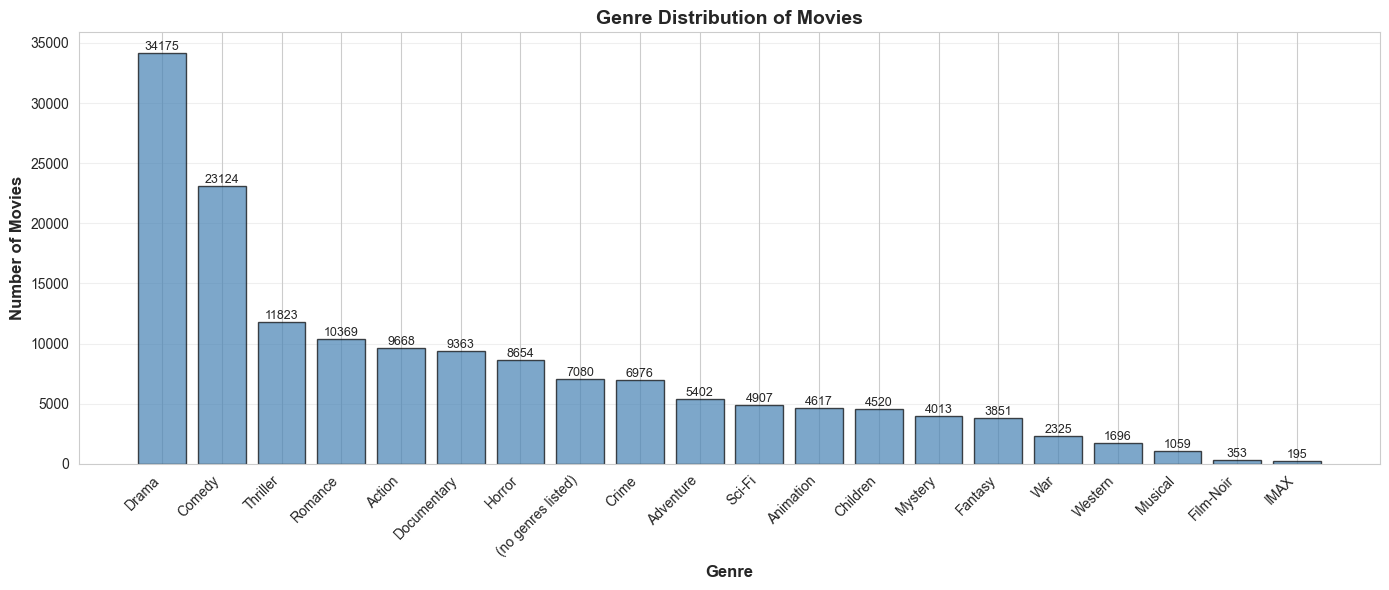

\Genre Distribution
Drama: 34175 movies
Comedy: 23124 movies
Thriller: 11823 movies
Romance: 10369 movies
Action: 9668 movies
Documentary: 9363 movies
Horror: 8654 movies
(no genres listed): 7080 movies
Crime: 6976 movies
Adventure: 5402 movies


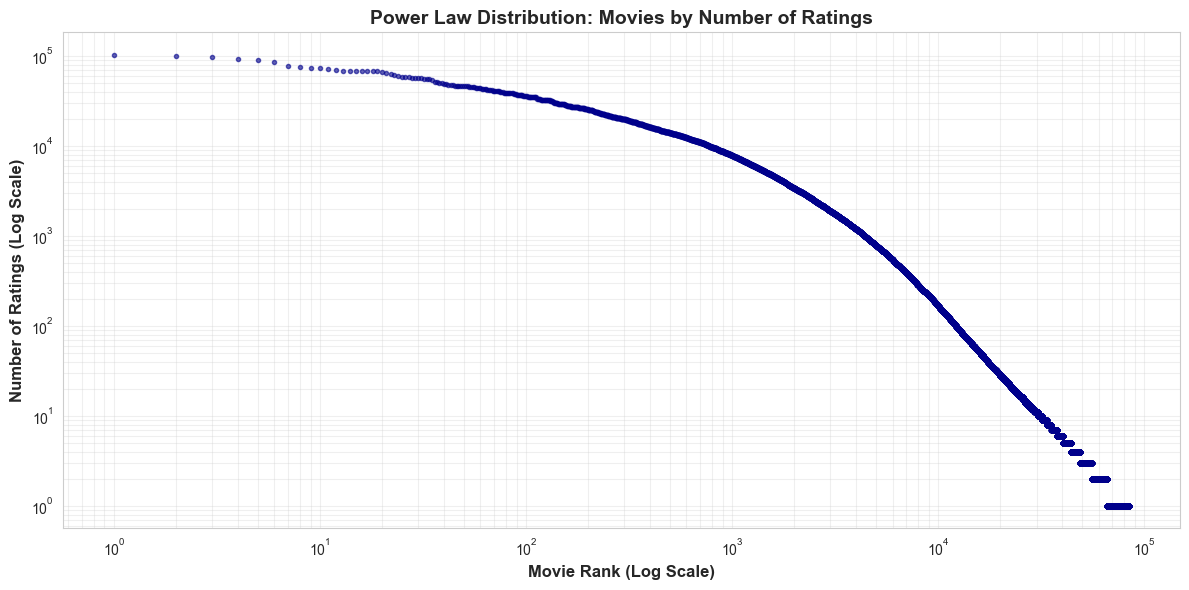


Movie Rating Distribution Stats
Total movies: 84432
Most rated movie: 102929 ratings
Median ratings per movie: 5.0
Mean ratings per movie: 379.0
Movies with 1 rating: 18607


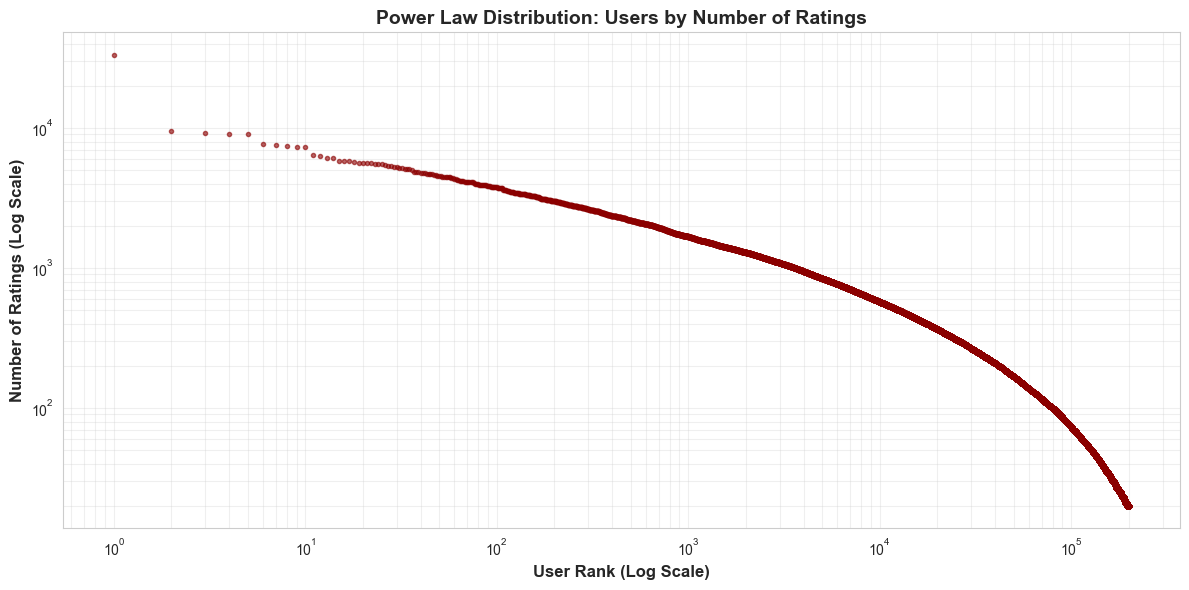


User Rating Distribution Stats
Total users: 200948
Most active user: 33332 ratings
Median ratings per user: 73.0
Mean ratings per user: 159.2
Users with 1 rating: 0


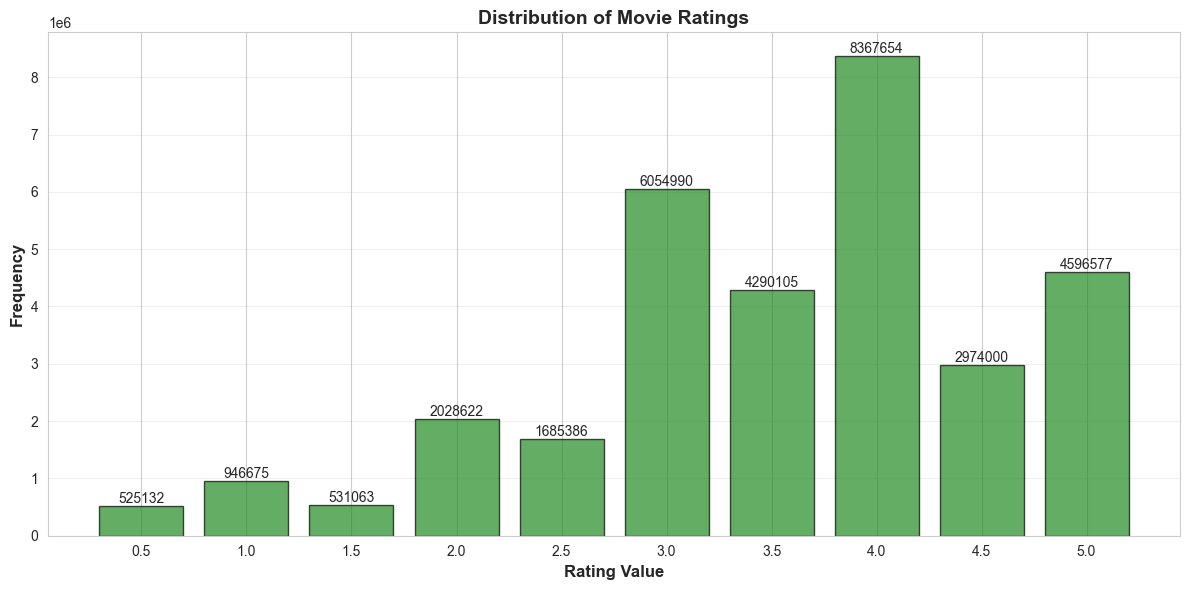


Rating Distribution
Rating 0.5: 525132 (1.6%)
Rating 1.0: 946675 (3.0%)
Rating 1.5: 531063 (1.7%)
Rating 2.0: 2028622 (6.3%)
Rating 2.5: 1685386 (5.3%)
Rating 3.0: 6054990 (18.9%)
Rating 3.5: 4290105 (13.4%)
Rating 4.0: 8367654 (26.1%)
Rating 4.5: 2974000 (9.3%)
Rating 5.0: 4596577 (14.4%)

Mean rating: 3.54
Median rating: 3.50
Total ratings: 32000204

Sparsity Analysis
Number of users: 200,948
Number of movies: 84,432
Total ratings: 32,000,204
Possible ratings: 16,966,441,536
Sparsity: 99.8114%
Density: 0.1886%


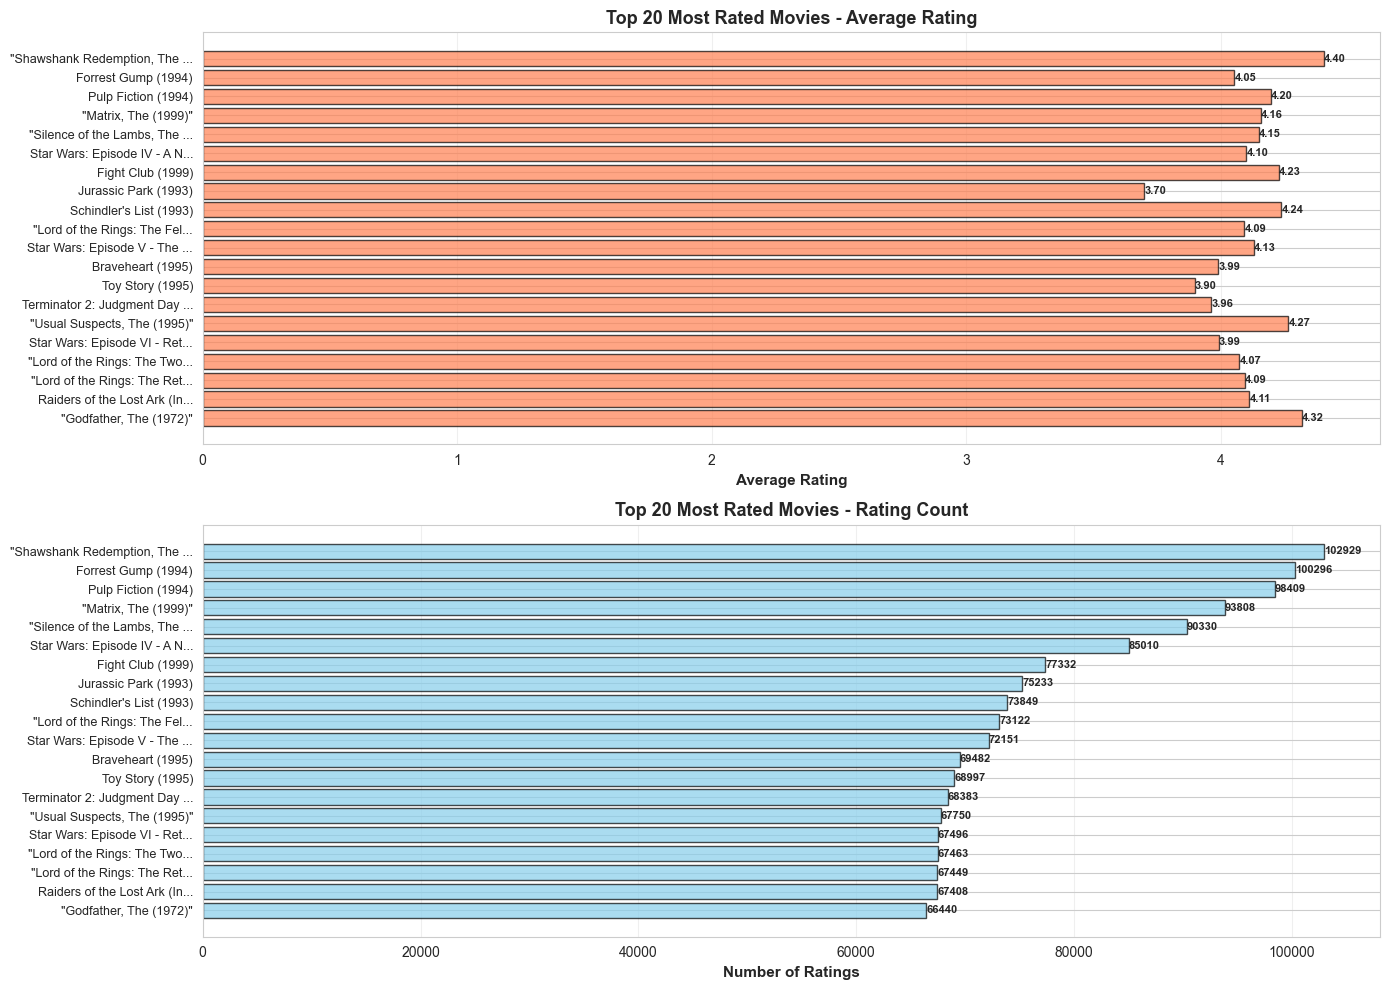


Top 20 Most Rated Movies
"Shawshank Redemption, The (1994)": Avg=4.40, Count=102929
Forrest Gump (1994): Avg=4.05, Count=100296
Pulp Fiction (1994): Avg=4.20, Count=98409
"Matrix, The (1999)": Avg=4.16, Count=93808
"Silence of the Lambs, The (1991)": Avg=4.15, Count=90330
Star Wars: Episode IV - A New Hope (1977): Avg=4.10, Count=85010
Fight Club (1999): Avg=4.23, Count=77332
Jurassic Park (1993): Avg=3.70, Count=75233
Schindler's List (1993): Avg=4.24, Count=73849
"Lord of the Rings: The Fellowship of the Ring, The (2001)": Avg=4.09, Count=73122


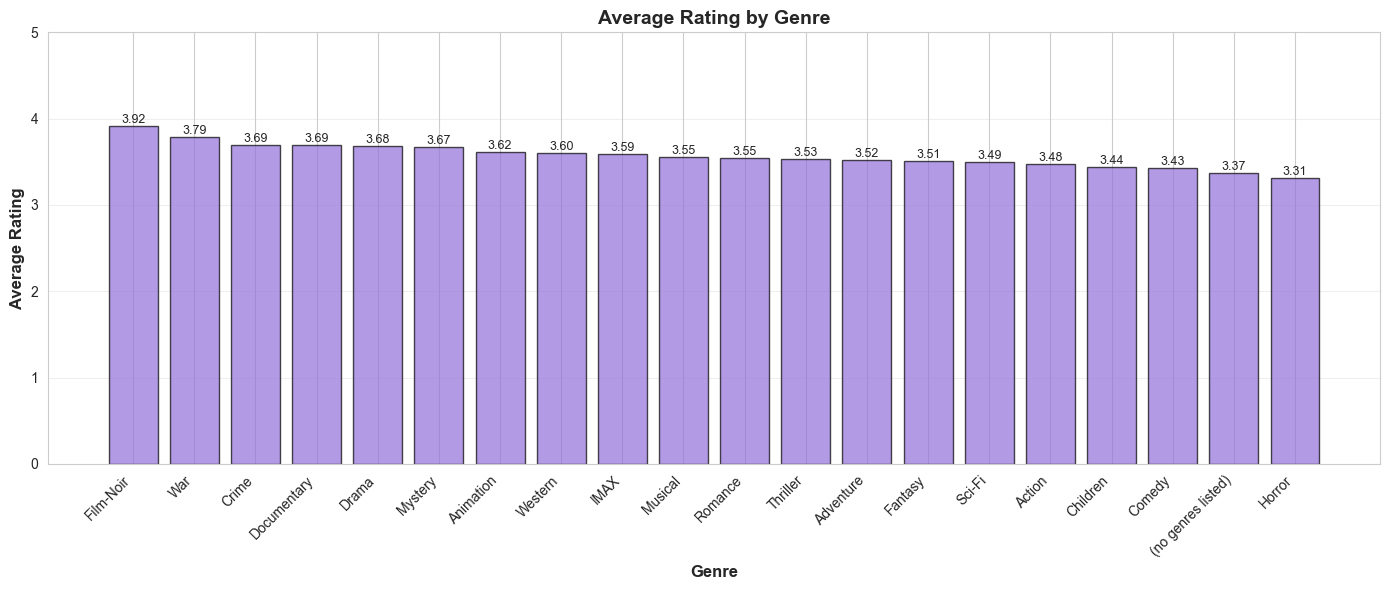


Average Rating by Genre
Film-Noir: 3.92 (304710 ratings)
War: 3.79 (1594110 ratings)
Crime: 3.69 (5373051 ratings)
Documentary: 3.69 (427353 ratings)
Drama: 3.68 (13973271 ratings)
Mystery: 3.67 (2615322 ratings)
Animation: 3.62 (2214562 ratings)
Western: 3.60 (596654 ratings)
IMAX: 3.59 (1494179 ratings)
Musical: 3.55 (1159516 ratings)
Romance: 3.55 (5524615 ratings)
Thriller: 3.53 (8679464 ratings)
Adventure: 3.52 (7590522 ratings)
Fantasy: 3.51 (3702759 ratings)
Sci-Fi: 3.49 (5717337 ratings)
Action: 3.48 (9665213 ratings)
Children: 3.44 (2731841 ratings)
Comedy: 3.43 (11206926 ratings)
(no genres listed): 3.37 (55498 ratings)
Horror: 3.31 (2492315 ratings)


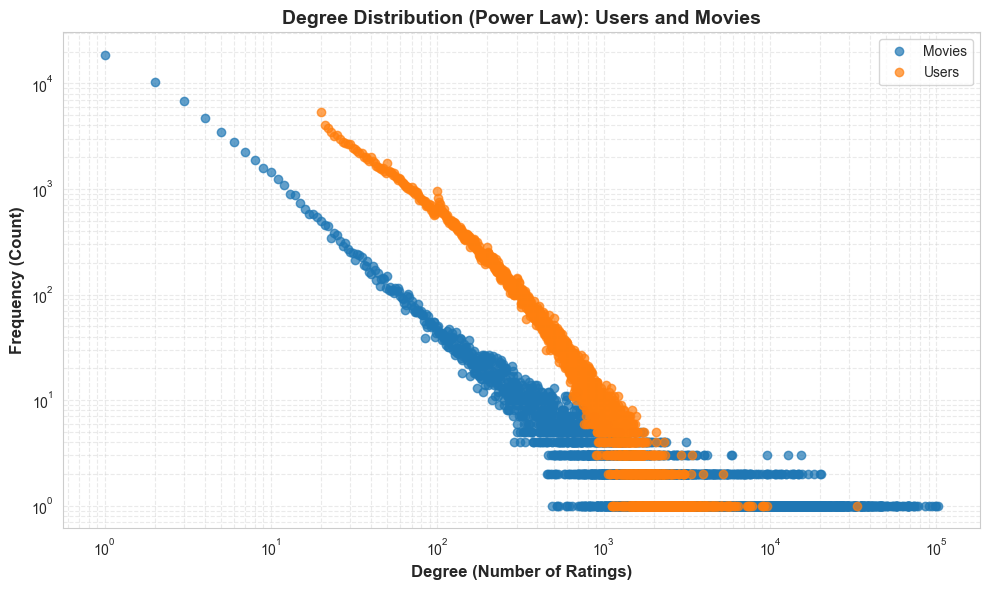


Degree Distribution Stats
Movies: min=1, max=102929, median=5.0, mean=379.0
Users:  min=20,  max=33332,  median=73.0, mean=159.2

Movies with degree 1: 18607
Users  with degree 1: 0

EDA COMPLETE!


In [16]:
ratings_path = "../data/ml-32m/ratings.csv"
movies_path = "../data/ml-32m/movies.csv"


run_eda(ratings_path, movies_path, image_path)